# On Cross-Validation and Regularization

First let's import some tools!

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split
from random import gauss as gs

In [3]:
# Below I make a dataframe that exhibits a correlation both between salary and age
# and between salary and years of experience. (There is also some noise in the
# dataset so that the correlation is not perfect!)

rands = []
for _ in range(1000):
    age = max(40 + gs(0, 10), 18)
    exp = max(10 + gs(0, 5), 0)
    salary = 1500 * age + 3000 * exp + 15000 + gs(0, 15000)
    row = [age, exp, salary]
    rands.append(row)
salaries = pd.DataFrame(rands, columns=['age', 'exp', 'salary'])

## Splitting into Train and Test

If we construct a good model of how age and years of experience affect salary, then we'll be able to use that model to make predictions of salary given *any* inputs to age and years of experience.

The motivating idea here is that we want to simulate the model predicting on never-before-seen data by using data that we already have! In particular, we'll train the model on only *some* of our data (the "training data"), leaving some out that we can then check the model against (the "testing data").

So we might, for example, just use scikit-learn's ```train_test_split()``` function:

In [29]:
# Let's use train_test_split here



In [30]:
# Let's scale our data!

# Question: WHY do we want to do this?

In [31]:
# Now we'll transform our two sets with the scaler fit to the training set.



In [32]:
# Let's fit a linear regression to our training set and score it on our testing set!



## Another Way: Cross-Validation

When we split our data above into training and testing sets, we specified a ratio such that the training set would be four times the size of our testing set.

One might think of this as splitting the data into fifths, and then assigning one of those five fifths to be the testing set, allowing the other four to compose the training set.

But once we've split the data into fifths, there's no particular reason to choose any one of those fifths to be the testing set. **In fact, there is a danger that some one of those fifths may be very *misleading* about the dataset as a whole.** So we might want to consider *all five* assignments at once! This is the essence of $k$-folds cross-validation. Suppose we build a linear regression and then want to cross-validate it.

We would:

- Split the data into $k$ pieces
- Give each piece a turn at playing the role of the testing set, i.e.:
    - For each piece $P$, train your model on all pieces but $P$, leaving $P$ for testing and scoring
- Take some sort of aggregate over the $k$-many assessments to reach your cross-validated score

Let's look at an example:

In [33]:
# Let's initialize a new Linear Regression estimator and cross-validate it



In [9]:
from matplotlib import pyplot as plt

plt.plot(salaries['age'], salaries['salary'], 'mx');

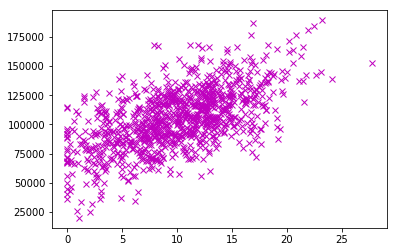

In [10]:
plt.plot(salaries['exp'], salaries['salary'], 'mx');

The point of cross-validation is to try to correct for train-test splits that just happen to produce unrepresentative samples. Let's build in some extra rows into our dataframe that will illustrate this.

In [11]:
mislead = []
for _ in range(100):
    age = max(40 + gs(0, 10), 18)
    exp = max(10 + gs(0, 5), 0)
    salary = -2000 * age - 1000 * exp + 200000 + gs(0, 15000)
    row = [age, exp, salary]
    mislead.append(row)
misleads = pd.DataFrame(mislead, columns=['age', 'exp', 'salary'])
salaries_plus_misleads = pd.concat([salaries, misleads], axis=0)

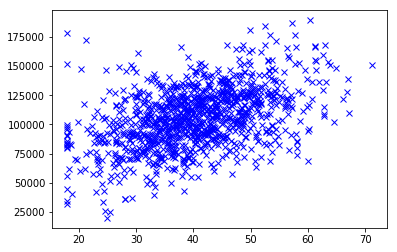

In [12]:
plt.plot(salaries_plus_misleads['age'], salaries_plus_misleads['salary'], 'bx');

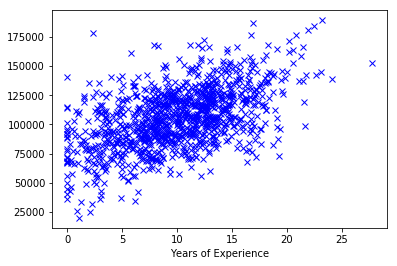

In [17]:
plt.plot(salaries_plus_misleads['exp'], salaries_plus_misleads['salary'], 'bx')
plt.xlabel('Years of Experience');

In [113]:
# Contriving our train_test split!



In [34]:
# Let's fit a new Linear Regression estimator to this new training set



In [35]:
# And score it on the new testing set



Yikes, what a terrible $R^2$ score!

Question: How can the score be negative?

In [36]:
# Verification that the baseline model has a score of 0:



Read over this blog post! https://machinelearningmastery.com/k-fold-cross-validation/

## Regularization

### Bias and Variance

High bias is easy to wrap one's mind around: Imagine pulling three red balls from an urn that has hundreds of balls of all colors in a uniform distribution. Then my sample is a terrible representative of the whole population. If I were to build a model by extrapolating from my sample, that model would predict that _every_ ball produced would be red! That is, this model would be incredibly biased.

High variance is a little bit harder to visualize, but it's basically the "opposite" of this. Imagine that the population of balls in the urn is mostly red, but also that there are a few balls of other colors floating around. Now imagine that our sample comprises a few balls, none of which is red. In this case, we've essentially picked up on the "noise", rather than the "signal". If I were to build a model by extrapolating from my sample, that model would be needlessly complex. It might predict that balls drawn before noon will be orange and that balls drawn after 8pm will be green, when the reality is that a simple model that predicted 'red' for all balls would be a superior model!

The important idea here is that there is a _trade-off_: If we have too few data in our sample (training set), or too few predictors, we run the risk of high _bias_, i.e. an underfit model. On the other hand, if we have too many predictors (especially ones that are collinear), we run the risk of high _variance_, i.e. an overfit model.

https://en.wikipedia.org/wiki/Overfitting#/media/File:Overfitting.svg

### Changing Our Loss Function

Suppose I have split my data into training and testing sets. Do I want my model to fit my training data _exactly_?

Often, the answer is actually 'NO!', because doing that will lead to an overfit model.

Overfitting is generally a result of high variance. High variance can be caused by:
- having irrelevant or too many predictors
- multicollinearity
- large coefficients

The first problem is about picking up on noise rather than signal.
The second problem is about having a least-squares estimate that is highly sensitive to random error.
The third is about having highly sensitive predictors.

Regularization is about introducing a factor into our model designed to enforce the stricture that the coefficients stay small, by penalizing the ones that get too large.

That is, we'll alter our loss function so that the goal now is not merely to minimize the difference between actual values and our model's predicted values. Rather, we'll add in a term to our loss function that represents the sizes of the coefficients.

There are two popular ways of doing this:

Lasso ("L1"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}|\beta_j|]$
<br/> <br/>

Ridge ("L2"): Minimize $\large\Sigma^{n_{obs.}}_{i=1}[(y_i - \Sigma^{n_{feat.}}_{j=0}\beta_j\times x_{ij})^2 + \lambda\Sigma^{n_{feat.}}_{j=0}\beta^2_j]$

**$\rightarrow$ Don't let these formulas be intimidating. The first term in each of these (the sum of squares) is the same, and is just the familiar loss function that we've always used. What distinguishes the Lasso Regression from the Ridge Regression is only the extra term on the right. The Lasso uses the absolute values of the coefficients, while the Ridge uses the squares of the coefficients.**

For a given value of $\lambda$, the Ridge makes for a gentler reining in of runaway coefficients. The Lasso will more quickly reduce the contribution of individual predictors down to insignificance.

For a nice discussion of these methods in Python, see https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b.

In [18]:
wine = pd.read_csv('learn-co-curriculum/ds-lessons-starter/curriculum-v2.0/Module-2/interaction_regularization/winequality_merged.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [19]:
wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
red_wine                  int64
dtype: object

In [37]:
X = wine.drop('quality', axis=1)
y = wine['quality']

# Train-test split


# Now let's scale our data.



# Scaling test set


# Fitting a Linear Regression


# Scoring the model on the test set



In [38]:
# reg_l = Lasso(alpha=0.5)



# Fitting the Lasso


# Scoring the Lasso on the training data



In [39]:
# Scoring on test


In [40]:
# Let's check out the lassoed coefficients



In [41]:
# reg_r = Ridge(alpha=20)



# Fitting the Ridge


# Scoring the Ridge on the training data



In [42]:
# Scoring on test



In [43]:
# Ridge coefficients


